In [57]:
import pandas as pd
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [58]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

In [59]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,process_outliers


In [60]:
# 读取数据
file_path = 'data_input_auto/wti_残差拟合.xlsx' 
xls = pd.ExcelFile(file_path)
data = pd.read_excel(xls, sheet_name='Sheet1')
data['DataTime'] = pd.to_datetime(data['DataTime'])

# 数据处理
data['GPR地缘风险指数_21DMA'] = data['GPR地缘风险指数'].rolling(window=21, min_periods=1).mean()

processed_data = process_outliers(data, column="WTI原油期货价格拟合残差/WTI连1-连4月差", window=20, std_multiplier=2)

processed_data.set_index('DataTime', inplace=True)

full_date_range = pd.date_range(start=processed_data.index.min(), end=processed_data.index.max() + pd.Timedelta(days=30), freq='B')
processed_data = processed_data.reindex(full_date_range)

processed_data

,WTI原油期货价格拟合残差/WTI连1-连4月差,美国经济惊喜指数,GPR地缘风险指数/20DMA,GPR地缘风险指数,GPR地缘风险指数/自动,ICE WTI成交量（连续）/30DMA,WTI连120合约价格60日环比,美元/卢布/7DMA30日环比,美国经济政策不确定性指数/7DMA,VIX指数/20DMA,GPR地缘风险指数_21DMA
1985-01-01,NaN,NaN,230.0400,97.43,230.04,NaN,NaN,NaN,103.8300,NaN,97.430000
1985-01-02,NaN,NaN,172.8600,157.37,115.68,NaN,NaN,NaN,200.1300,NaN,127.400000
1985-01-03,NaN,NaN,147.7167,81.36,97.43,NaN,NaN,NaN,152.1067,NaN,112.053333
1985-01-04,NaN,NaN,150.1300,167.30,157.37,NaN,NaN,NaN,143.6925,NaN,125.865000
1985-01-07,NaN,NaN,136.3557,121.40,105.31,NaN,NaN,NaN,209.0171,NaN,116.795714
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
processed_data['GPR地缘风险指数_21DMA_提前36天'] = processed_data['GPR地缘风险指数_21DMA'].shift(36)
processed_data['美国经济惊喜指数_提前28天'] = processed_data['美国经济惊喜指数'].shift(28)
processed_data['美国经济惊喜指数_提前21天'] = processed_data['美国经济惊喜指数'].shift(21)
processed_data['ICE WTI成交量（连续）/30DMA_提前30天'] = processed_data['ICE WTI成交量（连续）/30DMA'].shift(20)
processed_data['WTI连120合约价格60日环比_提前70天'] = processed_data['WTI连120合约价格60日环比'].shift(70)
processed_data['美元/卢布/7DMA30日环比_提前20天'] = processed_data['美元/卢布/7DMA30日环比'].shift(20)
processed_data['GPR地缘风险指数/20DMA_提前50天'] = processed_data['GPR地缘风险指数/20DMA'].shift(50)
processed_data['美国经济政策不确定性指数/7DMA_提前20天'] = processed_data['美国经济政策不确定性指数/7DMA'].shift(20)
processed_data['VIX指数/20DMA_提前20天'] = processed_data['VIX指数/20DMA'].shift(20)

fill_methods = {
    'GPR地缘风险指数_21DMA_提前36天': 'interpolate',    
    '美国经济惊喜指数_提前28天': 'interpolate' ,  
    '美国经济惊喜指数_提前21天': 'interpolate',
    'ICE WTI成交量（连续）/30DMA_提前30天': 'interpolate',
    'WTI连120合约价格60日环比_提前70天': 'interpolate',
    '美元/卢布/7DMA30日环比': 'interpolate',
    'GPR地缘风险指数/20DMA_提前50天': 'interpolate',
    '美国经济政策不确定性指数/7DMA_提前20天': 'interpolate',
    'VIX指数/20DMA_提前20天': 'interpolate'
} 
processed_data = fill_missing_values(processed_data, fill_methods, return_only_filled=False)


# 如果你需要将索引恢复为列，可以执行reset_index
processed_data.reset_index(inplace=True)
processed_data.rename(columns={'index': 'Date'}, inplace=True)

# 现在可以按 'Date' 列进行筛选了
data_filtered = processed_data[processed_data['Date'] >= '2023-03-01'].copy()

last_day = data_filtered['Date'][data_filtered['WTI原油期货价格拟合残差/WTI连1-连4月差'].last_valid_index()]
data_filtered = data_filtered[(data_filtered['Date'] > last_day) | data_filtered['WTI原油期货价格拟合残差/WTI连1-连4月差'].notna()]

data_filtered['GPR地缘风险指数_21DMA_提前36天_2024'] = data_filtered['GPR地缘风险指数_21DMA_提前36天']

data_filtered.loc[data_filtered['Date'] < '2024-01-01', 'GPR地缘风险指数_21DMA_提前36天_2024'] = np.nan

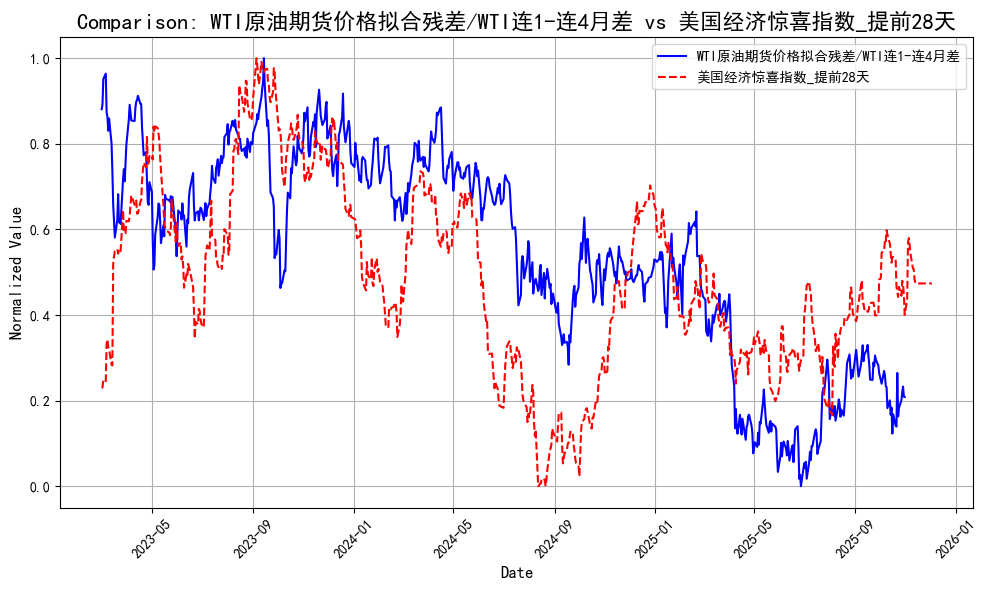

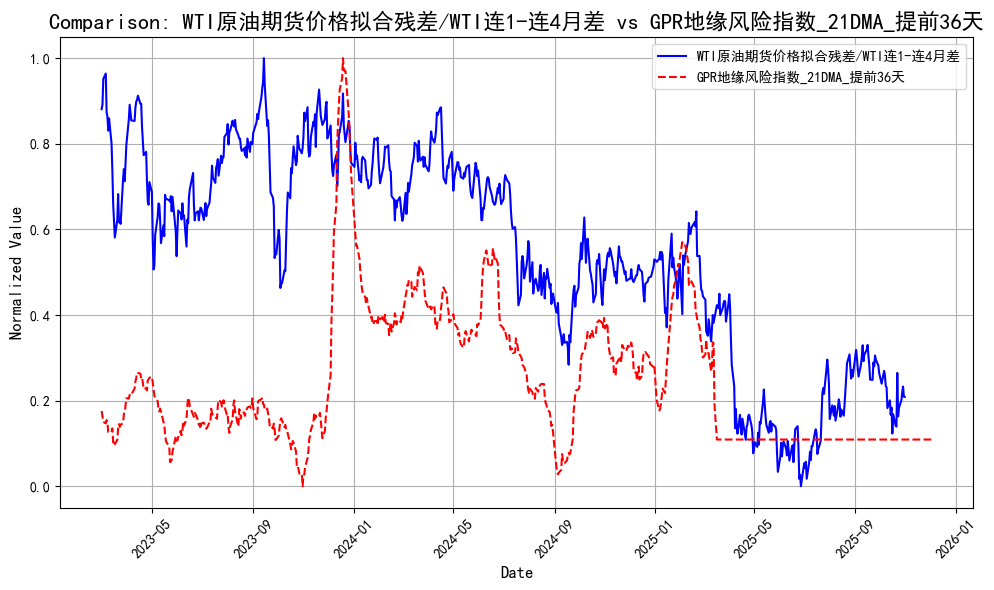

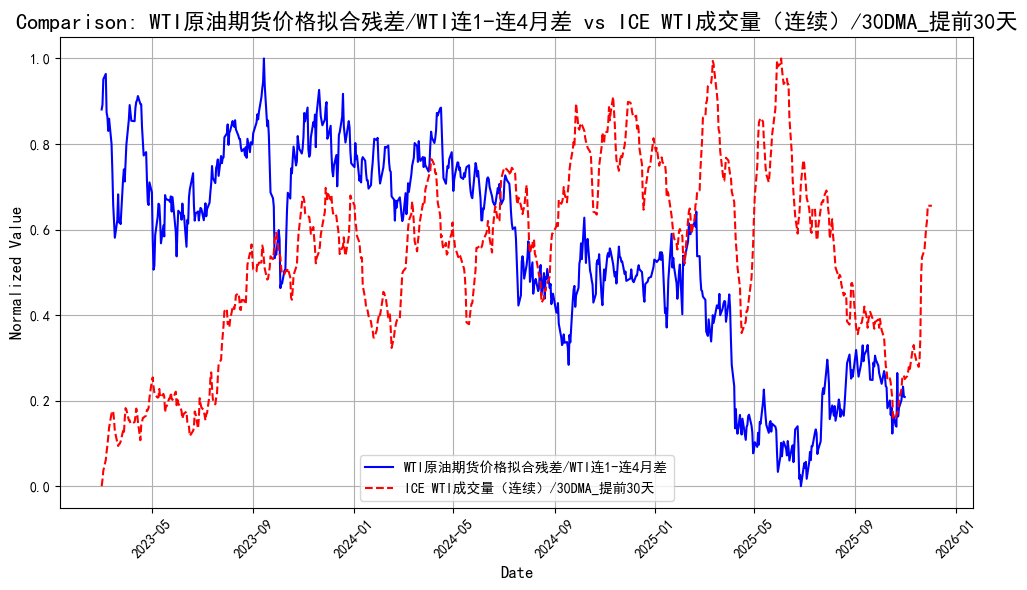

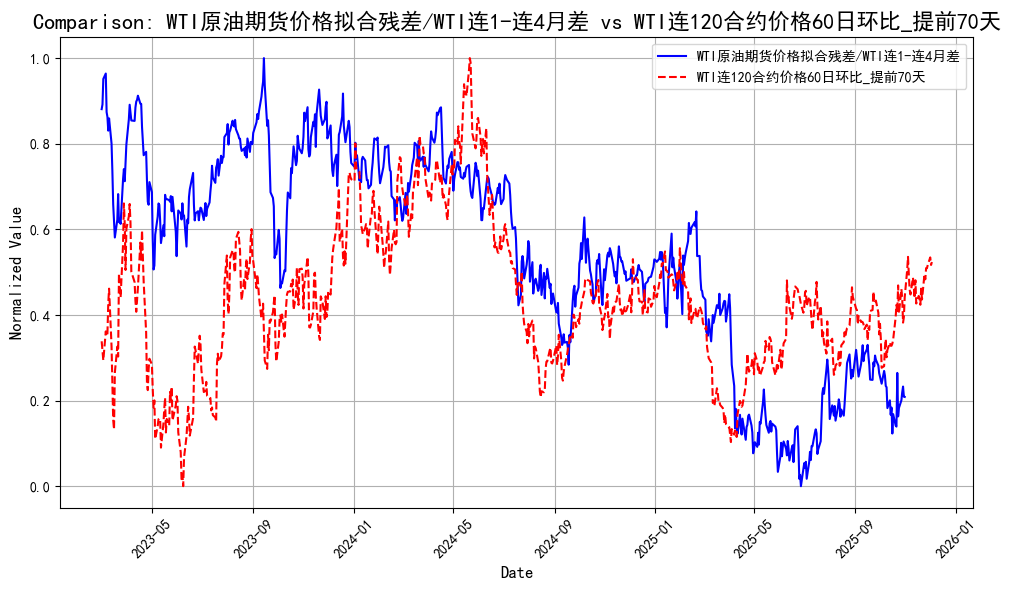

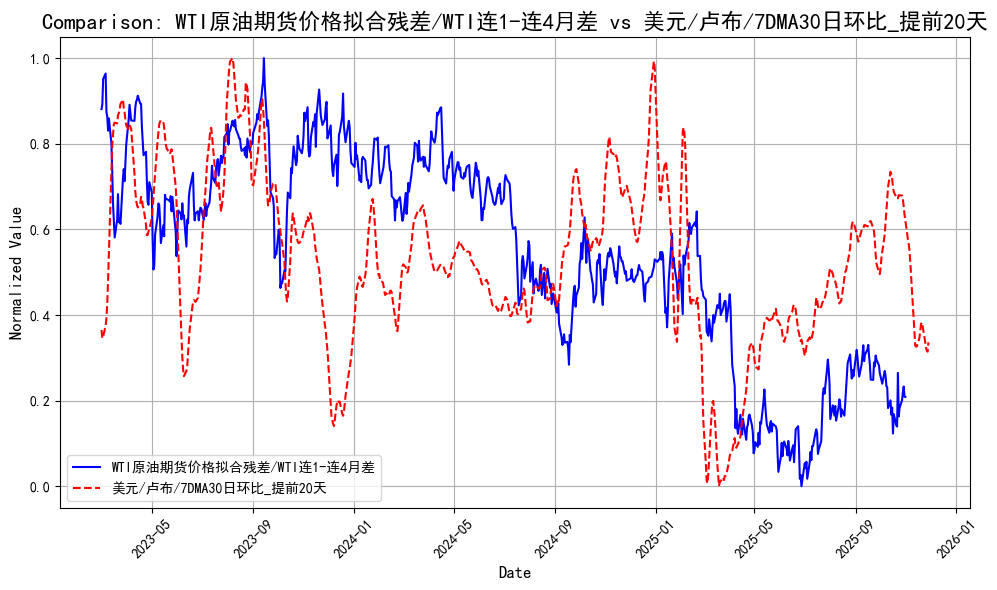

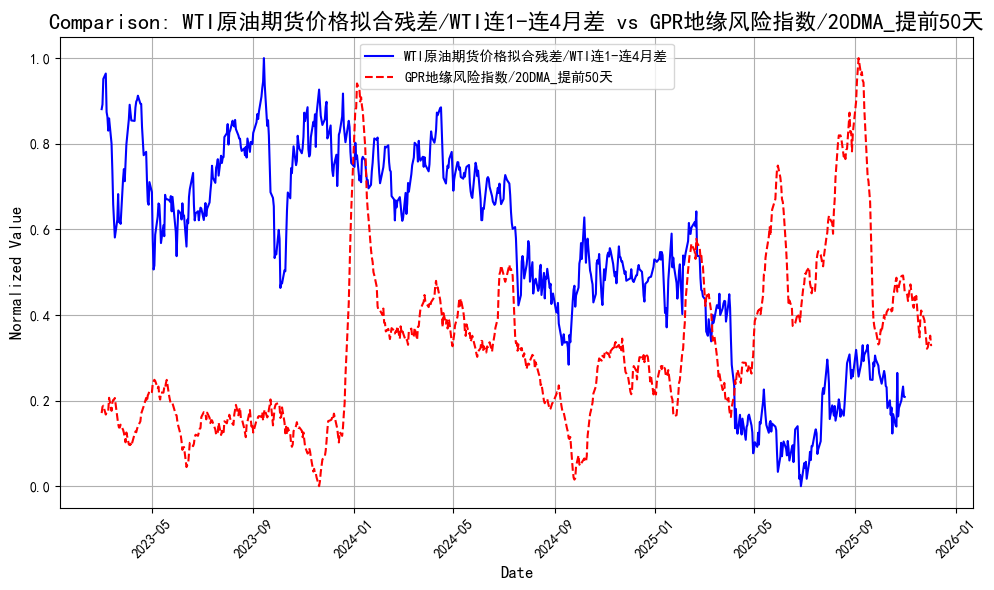

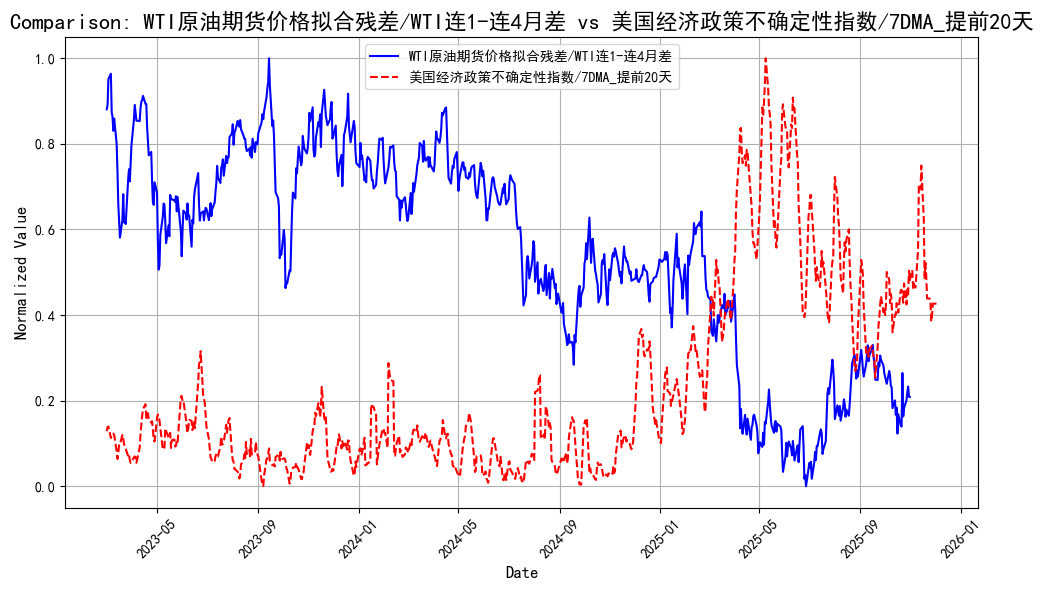

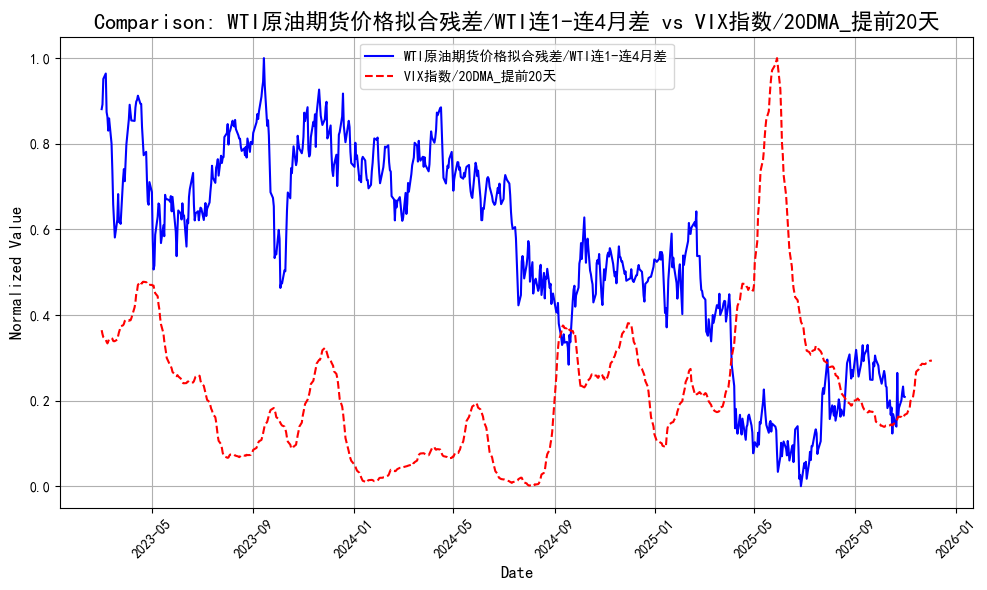

In [62]:
data_filtered_plot = data_filtered.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='WTI原油期货价格拟合残差/WTI连1-连4月差', 
    compare_cols=[ 
        '美国经济惊喜指数_提前28天',
        'GPR地缘风险指数_21DMA_提前36天',
        'ICE WTI成交量（连续）/30DMA_提前30天',
        'WTI连120合约价格60日环比_提前70天',
        '美元/卢布/7DMA30日环比_提前20天',
        'GPR地缘风险指数/20DMA_提前50天',
        '美国经济政策不确定性指数/7DMA_提前20天',
        'VIX指数/20DMA_提前20天'
        ]
)

In [ ]:
sheet_daily = data_filtered.copy()

# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 21
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

feature_columns = [
 '美国经济惊喜指数_提前28天',
 'GPR地缘风险指数_21DMA_提前36天',
# 'ICE WTI成交量（连续）/30DMA_提前30天',
 'WTI连120合约价格60日环比_提前70天',
 'WTI连120合约价格60日环比_提前70天',
# '美元/卢布/7DMA30日环比_提前20天',
 'GPR地缘风险指数/20DMA_提前50天',
 '美国经济政策不确定性指数/7DMA_提前20天',
# 'VIX指数/20DMA_提前20天'
]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['WTI原油期货价格拟合残差/WTI连1-连4月差']
X_test = test_data[feature_columns]
y_test = test_data['WTI原油期货价格拟合残差/WTI连1-连4月差']
X_future = future_data[feature_columns]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)
'''
# 训练模型
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.04,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=4,
    random_state=42        
)
'''
xgb = XGBRegressor(
    booster='gblinear',
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.01,
    reg_alpha=0.15,
    reg_lambda=0.02,
    random_state=42
)


xgb.fit(X_train_scaled, y_train)

# 预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)
y_future_pred = xgb.predict(X_future_scaled)

# 全数据集预测
X_all = np.vstack((X_train, X_test))
y_all = np.concatenate((y_train, y_test))
X_all_scaled = scaler.fit_transform(X_all)
model_all = xgb.fit(X_all_scaled,y_all)
y_future_pred_all = model_all.predict(X_future_scaled)

# 保存预测结果
test_data = test_data.copy()
future_data = future_data.copy()
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred
future_data.loc[:, '预测值_全值'] = y_future_pred_all

Gap between last actual value and first prediction: -3.7644036041259774


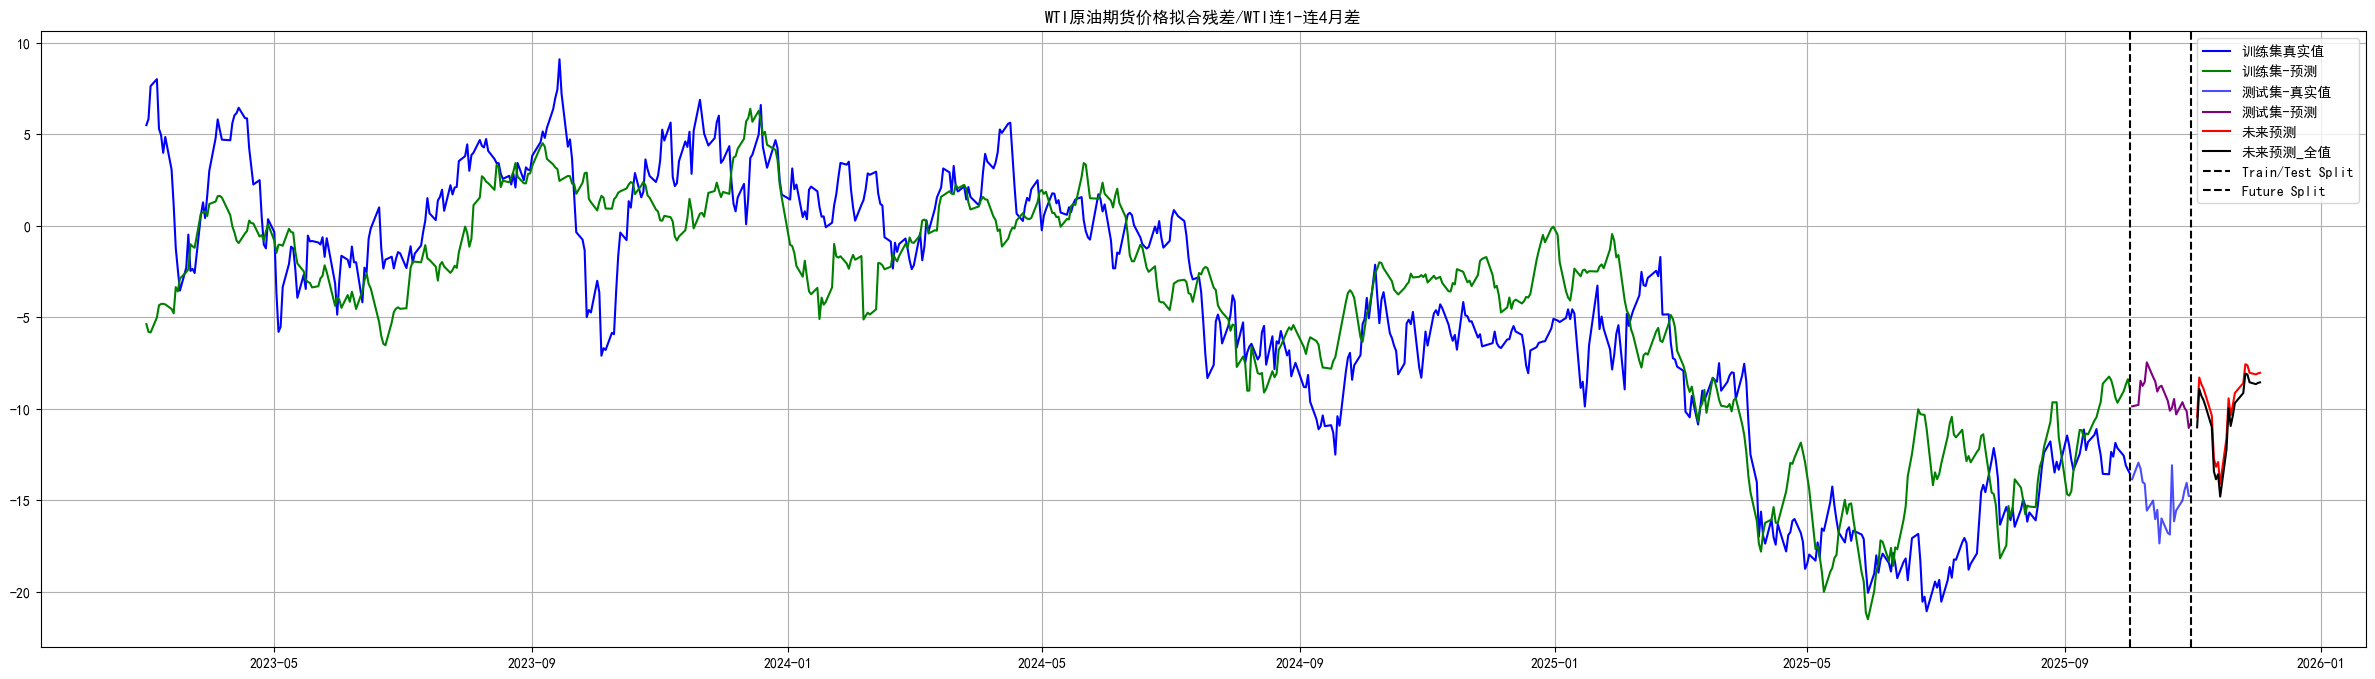

In [64]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全值'], label='未来预测_全值', color='black')

plt.axvline(x=train_data['Date'].iloc[-1], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('WTI原油期货价格拟合残差/WTI连1-连4月差')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# 获取特征重要性
feature_importance = xgb.get_booster().get_score(importance_type='weight')

# 获取原始特征名称列表
feature_names = X_train.columns.tolist()

# 打印特征重要性
for feature, importance in feature_importance.items():
    # 从特征名称中提取索引数字
    feature_idx = int(feature.replace('f',''))
    # 使用索引获取对应的原始特征名称
    original_name = feature_names[feature_idx]
    print(f"{original_name}: {importance:.2f}")


美国经济惊喜指数_提前28天: 2.03
GPR地缘风险指数_21DMA_提前36天: 1.04
WTI连120合约价格60日环比_提前70天: 0.43
WTI连120合约价格60日环比_提前70天: 0.43
GPR地缘风险指数/20DMA_提前50天: -1.39
美国经济政策不确定性指数/7DMA_提前20天: -3.38


---

In [66]:
# 合并训练集和测试集的预测结果
combined_df = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    'WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值': np.concatenate([y_train_pred, y_test_pred])
})

# 只保留2024年之后的数据
combined_df = combined_df[combined_df['Date'] >= '2024-01-01'].reset_index(drop=True)
# 保存到CSV文件
combined_df.to_csv('data_output_auto/WTI拟合残差_2024后预测.csv', index=False)
combined_df.tail()

,Date,WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值
460,2025-10-27,-9.638357
461,2025-10-28,-9.947171
462,2025-10-29,-10.130323
463,2025-10-30,-11.049122
464,2025-10-31,-10.776519


---

In [67]:

# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', 'WTI原油期货价格拟合残差/WTI连1-连4月差']]
test_actual = test_data[['Date', 'WTI原油期货价格拟合残差/WTI连1-连4月差']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '真实值']

# 创建包含未来预测值的DataFrame
future_df = pd.DataFrame({
    'Date': future_data['Date'],
    'WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值': future_data['预测值_全值']
})

# 获取未来预测值
future_pred = future_df[['Date', 'WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值']]
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/wti_残差项_合并数据.xlsx', index=False, float_format='%.2f')
merged_df

,Date,真实值,预测值
698,2025/12/03,NaN,-8.555321
697,2025/12/02,NaN,-8.583618
696,2025/12/01,NaN,-8.652009
695,2025/11/28,NaN,-8.548380
694,2025/11/27,NaN,-8.130989
...,...,...,...
4,2023/03/07,5.3047,NaN
3,2023/03/06,8.0239,NaN
2,2023/03/03,7.6427,NaN
1,2023/03/02,5.8453,NaN


In [68]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', 'WTI原油期货价格拟合残差/WTI连1-连4月差']],
    test_data[['Date', 'WTI原油期货价格拟合残差/WTI连1-连4月差']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']].rename(columns={'预测值': '预测值'}),
    future_data[['Date', '预测值_全值']].rename(columns={'预测值_全值': '预测值'})
], ignore_index=True).drop_duplicates(subset=['Date'], keep='last')[['Date', '预测值']]


# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
monthly_df.to_excel('eta/wti_残差项_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df.head()


,Date,实际值,预测值
33,2025/12/31,NaN,-8.596982
32,2025/11/30,NaN,-10.581043
31,2025/10/31,-14.872273,-9.325151
30,2025/09/30,-12.279757,-10.744499
29,2025/08/31,-14.685711,-13.828055


---

In [69]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "WTI原油期货价格-拟合残差/WTI连1-连4月差"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [70]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "WTI原油期货价格-拟合残差/WTI连1-连4月差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
